## Week 4, Lab 2: Predicting Chronic Kidney Disease in Patients
> Author: Matt Brems

We can sketch out the data science process as follows:
1. Define the problem.
2. Obtain the data.
3. Explore the data.
4. Model the data.
5. Evaluate the model.
6. Answer the problem.

In this lab, we're going to focus on steps exploring data, building models and evaluating the models we build.

There are three links you may find important:
- [A set of chronic kidney disease (CKD) data and other biological factors](./chronic_kidney_disease_full.csv).
- [The CKD data dictionary](./chronic_kidney_disease_header.txt).
- [An article comparing the use of k-nearest neighbors and support vector machines on predicting CKD](./chronic_kidney_disease.pdf).

## Step 1: Define the problem.

Suppose you're working for Mayo Clinic, widely recognized to be the top hospital in the United States. In your work, you've overheard nurses and doctors discuss test results, then arrive at a conclusion as to whether or not someone has developed a particular disease or condition. For example, you might overhear something like:

> **Nurse**: Male 57 year-old patient presents with severe chest pain. FDP _(short for fibrin degradation product)_ was elevated at 13. We did an echo _(echocardiogram)_ and it was inconclusive.

> **Doctor**: What was his interarm BP? _(blood pressure)_

> **Nurse**: Systolic was 140 on the right; 110 on the left.

> **Doctor**: Dammit, it's an aortic dissection! Get to the OR _(operating room)_ now!

> _(intense music playing)_

In this fictitious but [Shonda Rhimes-esque](https://en.wikipedia.org/wiki/Shonda_Rhimes#Grey's_Anatomy,_Private_Practice,_Scandal_and_other_projects_with_ABC) scenario, you might imagine the doctor going through a series of steps like a [flowchart](https://en.wikipedia.org/wiki/Flowchart), or a series of if-this-then-that steps to diagnose a patient. The first steps made the doctor ask what the interarm blood pressure was. Because interarm blood pressure took on the values it took on, the doctor diagnosed the patient with an aortic dissection.

Your goal, as a research biostatistical data scientist at the nation's top hospital, is to develop a medical test that can improve upon our current diagnosis system for [chronic kidney disease (CKD)](https://www.mayoclinic.org/diseases-conditions/chronic-kidney-disease/symptoms-causes/syc-20354521).

**Real-world problem**: Develop a medical diagnosis test that is better than our current diagnosis system for CKD.

**Data science problem**: Develop a medical diagnosis test that reduces both the number of false positives and the number of false negatives.

In [1]:
#import package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,plot_roc_curve, accuracy_score


import random

---

## Step 2: Obtain the data.

### 1. Read in the data.

In [2]:
df = pd.read_csv("chronic_kidney_disease_full.csv")
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd


In [3]:
#data points and no of features
df.shape

(400, 25)

In [4]:
#is there any null values?
df.isnull().sum().sum()

#unfortunately YES!

1012

### 2. Check out the data dictionary. What are a few features or relationships you might be interested in checking out?

Answer: Age, Coronary Artery Disease, Hypertension, Appetite

---

## Step 3: Explore the data.

### 3. How much of the data is missing from each column?

In [5]:
#check the missing values
df.isnull().sum().sort_values(ascending=False)

rbc      152
rbcc     131
wbcc     106
pot       88
sod       87
pcv       71
pc        65
hemo      52
su        49
sg        47
al        46
bgr       44
bu        19
sc        17
bp        12
age        9
ba         4
pcc        4
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
class      0
dtype: int64

In [6]:
#let's look if the distribution of our dependent variable is balanced
df["class"].value_counts()

ckd       250
notckd    150
Name: class, dtype: int64

### 4. Suppose that I dropped every row that contained at least one missing value. (In the context of analysis with missing data, we call this a "complete case analysis," because we keep only the complete cases!) How many rows would remain in our dataframe? What are at least two downsides to doing this?

> There's a good visual on slide 15 of [this deck](https://liberalarts.utexas.edu/prc/_files/cs/Missing-Data.pdf) that shows what a complete case analysis looks like if you're interested.

In [7]:
df.shape

(400, 25)

In [8]:
df_nonull = df.dropna()

Answer:

In [9]:
#oh no! we will lose 60% of the data
df_nonull.shape

(158, 25)

### 5. Thinking critically about how our data were gathered, it's likely that these records were gathered by doctors and nurses. Brainstorm three potential areas (in addition to the missing data we've already discussed) where this data might be inaccurate or imprecise.

Answer:

---

## Step 4: Model the data.

### 6. Suppose that I want to construct a model where no person who has CKD will ever be told that they do not have CKD. What (very simple, no machine learning needed) model can I create that will never tell a person with CKD that they do not have CKD?

> Hint: Don't think about `statsmodels` or `scikit-learn` here.

Answer: We can look at the models with the highest Sensitivity Rate or the True positive rate.

### 7. In problem 6, what common classification metric did we optimize for? Did we minimize false positives or negatives?

Answer: We minimize false negative.

### 8. Thinking ethically, what is at least one disadvantage to the model you described in problem 6?

Answer: The model might have more false positive, where the model predicted that the person has CKD but they don't really have (false positive), and may do treatments that they don't need that may be expensive and not necessary and might even be harmful

### 9. Suppose that I want to construct a model where a person who does not have CKD will ever be told that they do have CKD. What (very simple, no machine learning needed) model can I create that will accomplish this?

Answer: Model with high Specifity Rate or True Negative rate.

### 10. In problem 9, what common classification metric did we optimize for? Did we minimize false positives or negatives?

Answer: We minimize false positives

### 11. Thinking ethically, what is at least one disadvantage to the model you described in problem 9?

Answer: The model  prediction may be high in false negative, and that those with CKD are predicted they don't have CKD, this means they will not be treated timely and risk of getting worse

### 12. Construct a logistic regression model in `sklearn` predicting class from the other variables. You may scale, select/drop, and engineer features as you wish - build a good model! Make sure, however, that you include at least one categorical/dummy feature and at least one quantitative feature.

> Hint: Remember to do a train/test split!

In [10]:
df["class"].value_counts()

ckd       250
notckd    150
Name: class, dtype: int64

In [11]:
#data cleaning first
#drop rbcc and wbcc as they not in relevant information

df.drop(columns=['rbcc', 'wbcc'], inplace=True)

In [12]:
df.describe()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo,pcv
count,391.000000,388.000000,353.000000,354.000000,351.000000,356.000000,381.000000,383.000000,313.000000,312.000000,348.000000,329.000000
mean,51.483376,76.469072,1.017408,1.016949,0.450142,148.036517,57.425722,3.072454,137.528754,4.627244,12.526437,38.884498
std,17.169714,13.683637,0.005717,1.352679,1.099191,79.281714,50.503006,5.741126,10.408752,3.193904,2.912587,8.990105
min,2.000000,50.000000,1.005000,0.000000,0.000000,22.000000,1.500000,0.400000,4.500000,2.500000,3.100000,9.000000
25%,42.000000,70.000000,1.010000,0.000000,0.000000,99.000000,27.000000,0.900000,135.000000,3.800000,10.300000,32.000000
50%,55.000000,80.000000,1.020000,0.000000,0.000000,121.000000,42.000000,1.300000,138.000000,4.400000,12.650000,40.000000
75%,64.500000,80.000000,1.020000,2.000000,0.000000,163.000000,66.000000,2.800000,142.000000,4.900000,15.000000,45.000000
max,90.000000,180.000000,1.025000,5.000000,5.000000,490.000000,391.000000,76.000000,163.000000,47.000000,17.800000,54.000000


In [13]:
def fill_median(df):

    if np.isnan(df[this]):
        if df["class"]=="ckd":
            return median_ckd
        else:
            return median_notckd
    else:
        return df[this]
        

In [14]:
#"fill in median based whether it is ckd or notckd

missing_num = ["pot","sod","pcv","hemo","su","sg","al","bgr","bu","sc","bp","age"]
this = "x"
median_ckd=0
median_notckd=0

for feature in missing_num:
    this = feature
    median_ckd = df[df["class"]=="ckd"][feature].median()
    median_notckd = df[df["class"]!="ckd"][feature].median()
    
    df[feature] = df.apply(fill_median,axis=1)

- 6.Red Blood Cells(nominal)
	rbc - (normal,abnormal)
- 7.Pus Cell (nominal)
	pc - (normal,abnormal)
- 8.Pus Cell clumps(nominal)
	pcc - (present,notpresent)
- 9.Bacteria(nominal)
	ba  - (present,notpresent)

In [15]:
#for rbc and pc, 0 for normal and 1 for abnormal
df["rbc"] = df["rbc"].map(lambda x: 1 if x=="abnormal" else 0)
df["pc"] = df["pc"].map(lambda x: 1 if x=="abnormal" else 0)

In [16]:
#for pcc and ba, 0 for notpresent and 1 for present
df["pcc"] = df["pcc"].map(lambda x: 1 if x=="present" else 0)
df["ba"] = df["ba"].map(lambda x: 1 if x=="present" else 0)

***Transform the below categorical to 0 and 1***
- 19.Hypertension(nominal)	
	htn - (yes,no)
- 20.Diabetes Mellitus(nominal)	
	dm - (yes,no)
- 21.Coronary Artery Disease(nominal)
	cad - (yes,no)
- 22.Appetite(nominal)	
	appet	 - (good,poor)
- 23.Pedal Edema(nominal)
	pe - (yes,no)	
- 24.Anemia(nominal)
	ane	- (yes,no)
- 25.Class (nominal)		
	class	 - (ckd,notckd)

In [17]:
#assig 0 as No, and 1 as Yes
categ = ["htn","dm", "cad", "pe","ane"]

for c in categ:
    df[c] = df[c].map(lambda x: 1 if x=="yes" else 0)
    


In [18]:
#for appet, 0 for poor and 1 for good
df["appet"] = df["appet"].map(lambda x: 1 if x=="good" else 0)

#for class, 0 for notckd and 1 for ckd
df["class"] = df["class"].map(lambda x: 1 if x=="ckd" else 0)


In [19]:
df.isnull().sum().sum()

0

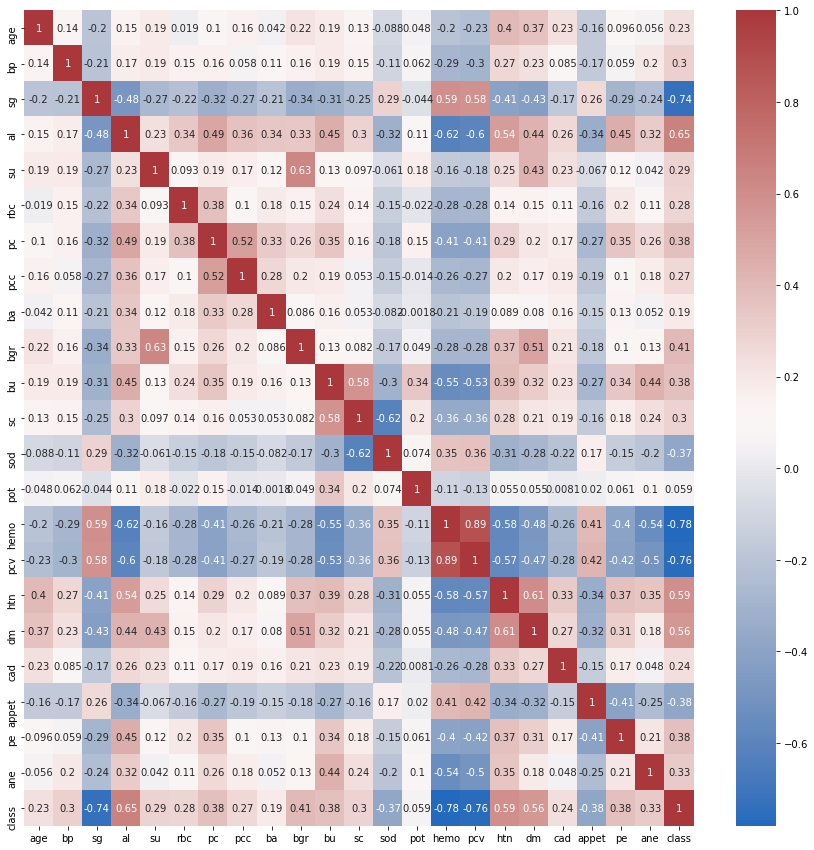

In [20]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(), annot=True, cmap="vlag");

In [21]:
#define independent and dependent variable
X=df.drop(columns="class")
y=df["class"]

In [22]:
#split our df to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 52, stratify=y)

In [23]:
#scale
ss = StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test)

In [24]:
k = 2

#instantiate the model
knn = KNeighborsClassifier(k)

#ffir
knn.fit(X_train_scaled, y_train )


KNeighborsClassifier(n_neighbors=2)

In [25]:
logr = LogisticRegression()
logr.fit(X_train_scaled, y_train )

LogisticRegression()

---

## Step 5: Evaluate the model.

### 13. Based on your logistic regression model constructed in problem 12, interpret the coefficient of one of your quantitative features.

In [26]:
#Score
print("KNN=2 Train Score", knn.score(X_train_scaled, y_train))
print("KNN=2 Test Score", knn.score(X_test_scaled, y_test))

KNN=2 Train Score 0.9866666666666667
KNN=2 Test Score 0.97


In [27]:
#Score
print("LR Train Score", logr.score(X_train_scaled, y_train))
print("LR Test Score", logr.score(X_test_scaled, y_test))

LR Train Score 1.0
LR Test Score 1.0


In [28]:
X.columns

Index(['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr', 'bu',
       'sc', 'sod', 'pot', 'hemo', 'pcv', 'htn', 'dm', 'cad', 'appet', 'pe',
       'ane'],
      dtype='object')

In [29]:
logr.coef_

array([[-0.20975513,  0.40033223, -2.00952647,  1.12172418,  0.21436528,
         0.62778662,  0.41383742,  0.17814197,  0.05924595,  0.77541947,
         0.01451801,  0.79817612, -0.51433042, -0.15147957, -1.52756701,
        -1.10818521,  0.84941061,  0.84769999,  0.05379262, -0.39139601,
         0.61893978,  0.15899681]])

In [30]:
coef=[-0.20975513,  0.40033223, -2.00952647,  1.12172418,  0.21436528,
         0.62778662,  0.41383742,  0.17814197,  0.05924595,  0.77541947,
         0.01451801,  0.79817612, -0.51433042, -0.15147957, -1.52756701,
        -1.10818521,  0.84941061,  0.84769999,  0.05379262, -0.39139601,
         0.61893978,  0.15899681]

In [31]:
dict(zip(X.columns, coef))

{'age': -0.20975513,
 'bp': 0.40033223,
 'sg': -2.00952647,
 'al': 1.12172418,
 'su': 0.21436528,
 'rbc': 0.62778662,
 'pc': 0.41383742,
 'pcc': 0.17814197,
 'ba': 0.05924595,
 'bgr': 0.77541947,
 'bu': 0.01451801,
 'sc': 0.79817612,
 'sod': -0.51433042,
 'pot': -0.15147957,
 'hemo': -1.52756701,
 'pcv': -1.10818521,
 'htn': 0.84941061,
 'dm': 0.84769999,
 'cad': 0.05379262,
 'appet': -0.39139601,
 'pe': 0.61893978,
 'ane': 0.15899681}

For every unit increase in Age, there is e^-0.21 times likely that person has CKD

### 14. Based on your logistic regression model constructed in problem 12, interpret the coefficient of one of your categorical/dummy features.

***appet = -0.39139601***
- If appet is 1 (good), there is e^-0.39 possibility that the person has CKD

### 15. Despite being a relatively simple model, logistic regression is very widely used in the real world. Why do you think that's the case? Name at least two advantages to using logistic regression as a modeling technique.

Answer: Logistic Regression has regularization and simplify the building of the models. It is also like Linear Regression where we can get the coef of the features that is interpretable.

### 16. Does it make sense to generate a confusion matrix on our training data or our test data? Why? Generate it on the proper data.

> Hint: Once you've generated your predicted $y$ values and you have your observed $y$ values, then it will be easy to [generate a confusion matrix using sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

In [32]:
y_pred = logr.predict(X_test_scaled)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
(tn, fp, fn, tp)

(37, 0, 0, 63)

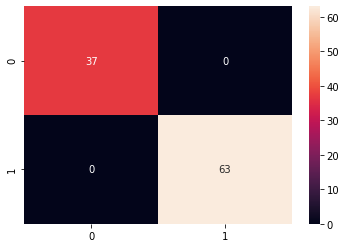

In [33]:
cfm = confusion_matrix(y_test, y_pred)
sns.heatmap(cfm, annot=True);

### 17. In this hospital case, we want to predict CKD. Do we want to optimize for sensitivity, specificity, or something else? Why? (If you don't think there's one clear answer, that's okay! There rarely is. Be sure to defend your conclusion!)

Answer: Ideally we want to achieve both. If I only choose one, I would probably choose Sensitivity, so all patients that have CKD will be predicted correctly, and the patient that really have no CKD may have second opinion that can negate the prediction correctly.

### 18 (BONUS). Write a function that will create an ROC curve for you, then plot the ROC curve.

Here's a strategy you might consider:
1. In order to even begin, you'll need some fit model. Use your logistic regression model from problem 12.
2. We want to look at all values of your "threshold" - that is, anything where .predict() gives you above your threshold falls in the "positive class," and anything that is below your threshold falls in the "negative class." Start the threshold at 0.
3. At this value of your threshold, calculate the sensitivity and specificity. Store these values.
4. Increment your threshold by some "step." Maybe set your step to be 0.01, or even smaller.
5. At this value of your threshold, calculate the sensitivity and specificity. Store these values.
6. Repeat steps 3 and 4 until you get to the threshold of 1.
7. Plot the values of sensitivity and 1 - specificity.

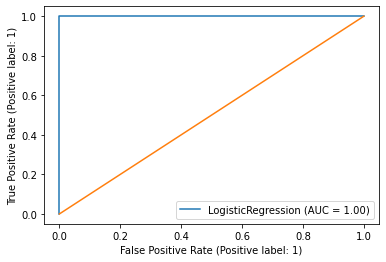

In [34]:
# ROC curve
plot_roc_curve(logr, X_test_scaled, y_test)
# add worst case scenario line
plt.plot([0,1],[0,1],label='baseline', linestyle='-');
# add a legend

In [35]:
#if we want to change our threshold
def get_predictions(proba, threshold):
    return [0 if prob < threshold else 1 for prob in proba]

In [36]:
threshold_list = [0.25,0.4, 0.5, 0.6, 0.75, 0.8]


for thresh in threshold_list:
    predicted_class = get_predictions(logr.predict_proba(X_test_scaled) [:,1], thresh)
    acc = accuracy_score(y_test, predicted_class)
    print('Threshold: ', thresh, '----- Acuracy:', acc)

Threshold:  0.25 ----- Acuracy: 0.99
Threshold:  0.4 ----- Acuracy: 1.0
Threshold:  0.5 ----- Acuracy: 1.0
Threshold:  0.6 ----- Acuracy: 1.0
Threshold:  0.75 ----- Acuracy: 0.99
Threshold:  0.8 ----- Acuracy: 0.98


*** from 40-60% threshold we are able to get 100% ***

### 19. Suppose you're speaking with the biostatistics lead at Mayo Clinic, who asks you "Why are unbalanced classes generally a problem? Are they a problem in this particular CKD analysis?" How would you respond?

Answer: If we have unbalanced classes, for example the majority are in the positive class (for this model we have more CKD - 250, and NOTCKD - 150), since there is more data supporting the CKD, the model might predict more CKD than NOTCKD

### 20. Suppose you're speaking with a doctor at Mayo Clinic who, despite being very smart, doesn't know much about data science or statistics. How would you explain why unbalanced classes are generally a problem to this doctor?

Answer: We need as much data for both cases, as having more data for one class, then it is also telling that most patient will likely to be predicted as one of the majority class when it seems not to be the case, we just don't have the enough balance data. 

### 21. Let's create very unbalanced classes just for the sake of this example! Generate very unbalanced classes by [bootstrapping](http://stattrek.com/statistics/dictionary.aspx?definition=sampling_with_replacement) (a.k.a. random sampling with replacement) the majority class.

1. The majority class are those individuals with CKD.
2. Generate a random sample of size 200,000 of individuals who have CKD **with replacement**. (Consider setting a random seed for this part!)
3. Create a new dataframe with the original data plus this random sample of data.
4. Now we should have a dataset with around 200,000 observations, of which only about 0.00075% are non-CKD individuals.

In [37]:
#randomly select with replacement
df_class1 = df[df["class"]==1].sample(n=200_000,replace=True)
df_class1.shape

(200000, 23)

In [38]:
df_class1["class"].value_counts()

1    200000
Name: class, dtype: int64

In [39]:
#combine the original df and the bootstrapped df
df_unbalance = pd.concat([df, df_class1])

In [40]:
df_unbalance.shape

(200400, 23)

In [41]:
df_unbalance["class"].value_counts()

1    200250
0       150
Name: class, dtype: int64

### 22. Build a logistic regression model on the unbalanced class data and evaluate its performance using whatever method(s) you see fit. How would you describe the impact of unbalanced classes on logistic regression as a classifier?
> Be sure to look at how well it performs on non-CKD data.

In [42]:
#define independent and dependent variable
X=df_unbalance.drop(columns="class")
y=df_unbalance["class"]

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=52)

In [44]:
logr_unb = LogisticRegression()

In [45]:
logr_unb.fit(X_train,y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [46]:
logr_unb.score(X_train,y_train)

0.9999268130405855

In [47]:
logr_unb.score(X_test,y_test)

0.9998802395209581

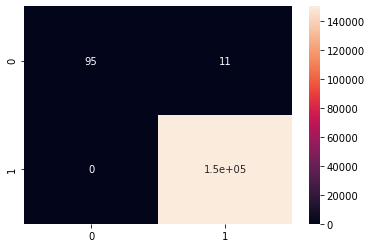

In [48]:
y_pred = logr_unb.predict(X_train)
cfm = confusion_matrix(y_train, y_pred)
sns.heatmap(cfm, annot=True);

In [49]:
tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()
(tn, fp, fn, tp)

(95, 11, 0, 150194)

In [50]:
#sensitivity (True Positive Rates)
#Sensitivity = True Positives / (True Positives + False Negatives)
tp/(tp + fn)


1.0

In [51]:
#specificity
tn/(tn + fp)

0.8962264150943396

Our specifity rate is lower in unbalanced dataset. It predicted more false positive, since our data has majority of positive cases

---

## Step 6: Answer the problem.

At this step, you would generally answer the problem! In this situation, you would likely present your model to doctors or administrators at the hospital and show how your model results in reduced false positives/false negatives. Next steps would be to find a way to roll this model and its conclusions out across the hospital so that the outcomes of patients with CKD (and without CKD!) can be improved!